In [22]:
from netCDF4 import Dataset
import glob
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import describe
from tqdm import tqdm

In [2]:
try:
    lats = np.load("lats.npy")
    lons = np.load("lons.npy")
except:
    files = glob.glob("data/aoml/**/*.nc", recursive=True)
    print(len(files))

    lats = []
    lons = []

    for f in tqdm(files):
        d = Dataset(f)
        lat = d.variables["LATITUDE"][:]
        lon = d.variables["LONGITUDE"][:]
        lats.extend(lat)
        lons.extend(lon)
        #temps = d.variables["TEMP_ADJUSTED"]

    np.save("lats", lats)
    np.save("lons", lons)

DescribeResult(nobs=121980, minmax=(1.0, 540.0), mean=43.35817347106083, variance=3213.935131465657, skewness=5.97461917129736, kurtosis=42.77629046372894)


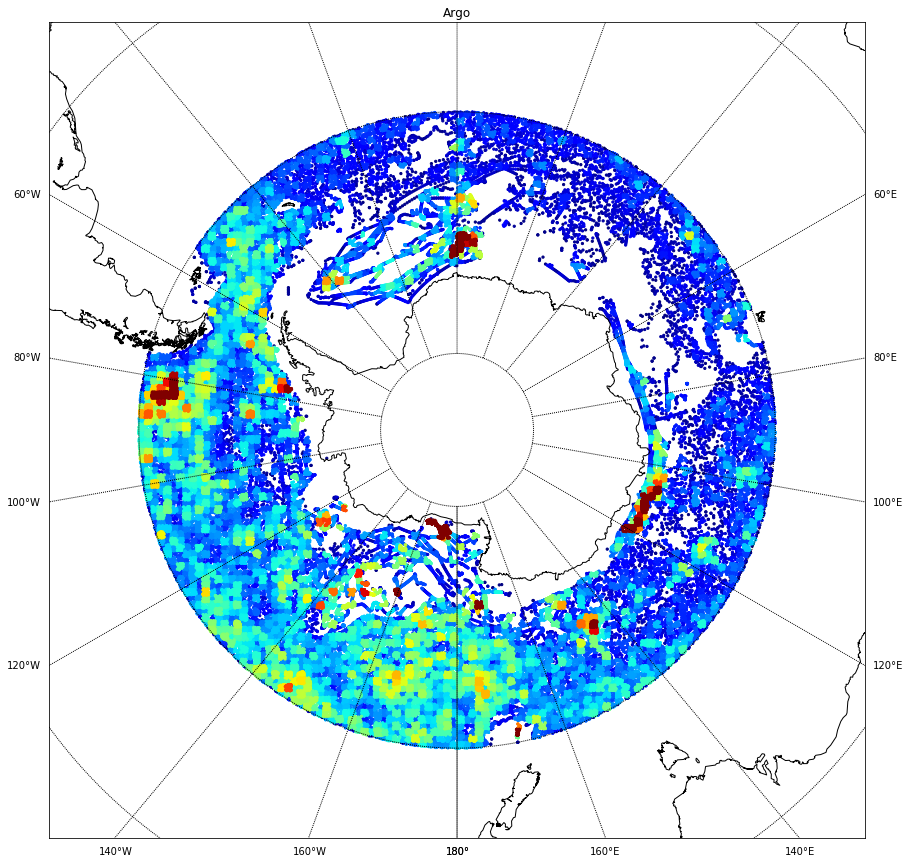

In [27]:
# setup north polar stereographic basemap.
# The longitude lon_0 is at 6-o'clock, and the
# latitude circle boundinglat is tangent to the edge
# of the map at lon_0. Default value of lat_ts
# (latitude of true scale) is pole.
fig = plt.figure(figsize=(15,15))
m = Basemap(projection='spstere',boundinglat=-40,lon_0=180,resolution='l')
m.drawcoastlines()
#m.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-50, 0, 20))
m.drawmeridians(np.arange(-180, 181, 20), labels=[1,1,0,1])
#m.drawmapboundary(fill_color='aqua')
plt.title("Argo")

x, y = m(lons, lats)
hh, locx, locy = np.histogram2d(x, y, bins=100)
# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
print(describe(z))
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]
#m.imshow(heatmap, interpolation='bicubic', cmap="jet")
m.scatter(x2, y2, c=z2, s=5, alpha=1, cmap="jet", vmax=100)
plt.show() 